Как Вы уже знаете (если не знаете, рекомендуем посмотреть [5-ую](https://www.youtube.com/watch?v=cAJp2hh-_q8&t=4831s) и [6-ую](https://www.youtube.com/watch?v=RVk2RUW9Euk&t=40s) лекции нашего курса), в современных задачах обработки изображений, будь то задача обнаружения объектов, задача распознавания образов, задача (семантической) сегментации, задача классификации изображений и другие, всё чаще используют **свёрточные нейросети** (*Convolutional Neural Networks*, *CNN*).

Они показывают очень хорошие результаты, за ними стоит как [математический аппарат](https://stats.stackexchange.com/questions/269854/are-there-mathematical-reasons-for-convolution-in-neural-networks-beyond-expedie), так и эвристики, полученные опытным путём.

В данном задании Вам предстоит познакомиться с архитектурами *AlexNet*, *VGG* и *Inception* и для каждой из этих моделей использовать технику **Transfer Learning**.  

* **Transfer Learning** - это процесс дообучения на **новых данных** какой-либо нейросети, уже обученной до этого на других данных, обычно на каком-нибудь хорошем, большом (миллионы картинок) датасете (например, [ImageNet](http://www.image-net.org/) ~ 14 млн картинок).

<h2 style="text-align: center;"><b>VGG</b></h3>


<h2 style="text-align: center;"><b>Inception v1</b></h3>

<h2 style="text-align: center;"><b>Transfer Learning</b></h3>

Теперь мы перейдем к тому, как можно использовать уже обученные нейросети, чтобы ускорить свою работу.

Давайте вспомним общую архитектуру CNN:

<img src="https://drive.google.com/uc?id=14pApKqQjnmWMXazY0HHjREn9rI9uwCQg">

С помощью операций *свёртки (convolution)* и *пулинга (pooling)* всё, что расположено до этапа *classification*, по сути **извлекает признаки из объектов, подающихся на вход** (картинок, в данном случае). То есть вместо того, чтобы самим пытаться как-то описать картинки для хорошей работы классификатора, мы предоставляем заняться этим нейросети (обучая её методом обратного распространения ошибки ([лекция 4](https://www.youtube.com/watch?v=HZDOhHAg5_g))).

<h2 style="text-align: center;"><b>Описание метода</b></h3>

Представим теперь, что eсть свой набор данных, и Вы хотите научить сеть классифицировать объекты из Вашей выборки.  
Есть 4 возможных подхода к задаче:

* **1. Написать свою собственную нейронную сеть**
    * Если Вас зовут не Ian Godfellow, Geoffry Hinton или Andrew Ng, то не рекомендуется пользоваться этим способом
    * May the force be with You

* **2. CNN как средство для извлечения признаков (Feature Extractor)** 
    * Берём сетку, обученную на ImageNet 
    * Убираем последние Fully-Connected слои сети, отвечающие за классификацию. Веса предыдущих слоёв **заморожены**, мы их не трогаем. Теперь сеть выдаёт не метки классов, а то, что поступало на вход Fully-Connected (развёрнутый в строку "параллелепипед" HxWxNUM_FILTERS с последнего слоя перед FC)
    * Запускаем сеть на новом датасете, получаем выходы сети для всех объектов - это и есть их признаки, полученные сетью
    * Обучаем на этих признаках какой-либо классификатор (свою Fully-Connected сеть, например)
    * Теперь у нас есть сеть, работающая хорошо на нашем датасете

* **3. CNN, которую можно дообучить (Fine Tuning)**  
    * Берём сетку, обученную на ImageNet  
    * Убираем последние Fully-Connected слои сети, отвечающие за классификацию.  
    * Теперь всё же *распространяем backpropagation ещё на сколько-то слоёв назад (размораживаем веса в этих слоях)*, чтобы скорректировать их под новые данные. Можно распространить обучение и на всю сеть, но часто первые слои всё же замораживают, поскольку они (как ожидается) извлекают более общие признаки. А ещё обучать всю сеть всё же дольше, чем несколько слоёв. Всё зависит от того, какого качества Вы хотите добиться
    * Теперь сеть выдаёт не метки классов, а то, что поступало на вход Fully-Connected (веса последних (или всех) слоёв были изменены под наши данные)
    * Обучаем на этих признаках какой-либо классификатор (свою Fully-Connected сеть, например)
    * Теперь у нас есть сеть, работающая хорошо на нашем датасете

* **4. Использовать предобученную модель "из коробки"**  
    * То есть взять уже готовую нейронную сеть и использовать её (её параметры (W, b..), ведь сеть характеризуется параметрами, если архитектура известна) для решения своей задачи. Например, [здесь](https://github.com/BVLC/caffe/wiki/Model-Zoo) люди часто выкладывают веса моделей, обученных для решения их специфических задач.  


В зависимости от количества и природы Ваших данных есть выбор из **нескольких стратегий Transfer Learning**, а именно:

* *У Вас **мало данных** ($\le$ 10k), и они **похожи** на данные, на которых была обучена сеть до этого*  
Если данные совсем похожи, можно попробовать использовать готовую модель. Если качество Вас не устраивает, то тогда стоит использовать CNN для извлечения признаков и обучить свой классификатор на этих данных (2-ой способ выше). Так как данные похожи на те, на которых обучалась сеть, то высокоуровневые признаки, полученные с помощью последних слоёв сети, должны оказаться информативными. Если делать в этом случае Fine-Tuning (3 способ), то сеть может переобучиться, поскольку данных мало.
* *У Вас **мало данных** ($\le$ 10k), и они **не похожи** на данные, на которых была обучена сеть до этого*  
Самый невыгодный случай. Здесь мы не можем ожидать от сети, что выходы последних слоёв будут информативными для новых данных. Следует также действовать в соответствие со 2-ым способом, но брать как признаки выходы более ранних слоёв, ведь, как мы помним, они (как ожидается) соответствуют более общим паттернам в данных.
* *У Вас **много данных** ($\ge$ 10k), и они **похожи** на данные, на которых была обучена сеть до этого*  
В этом случае можем смело делать Fine-Tuning (3 способ) (если не устроило качество модели "из коробки"), ведь данных много, и вероятность переобучения меньше. В данном случае имеет смысл попробовать разморохить веса последних нескольких слоёв (зависит от того, сколько у Вас времени и вычислительной мощности, можно разморозить и всю сеть)
* *У Вас **много данных** ($\ge$ 10k), и они **не похожи** на данные, на которых была обучена сеть до этого*
В принципе, подход тот же, что и в случае похожих данных, то есть мы файнтюним практически всю нейросеть. Однако мы вольны в этом случае полнстью менять все параметры (и гиперпараметры) нейросети, ведь по сути мы пользуемся только её архитектурой, забывая о том, что она уже была когда-то обучена. Но часто веса предобученной сети оставляют в качестве инициализации для обучения на новых данных.

In [ ]:
import os
from tqdm.autonotebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')  

<ipython-input-1-1cda60e2a90b>:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


## В чём состоит задание

Вам предстоит попробовать использовать  типа архитектур свёрточных нейросетей - **AlexNet (сделано за Вас в примере), VGG16, Inception_v3** - как *Feature Extractor*, с помощью *Fine Tuning* и *"из коробки"*. 

**Для каждого пункта нужно:**
- вывести график loss'а на обучающей и на валидационной выборке
- вывести качество модели (accuracy)

### Данные  

В данном задании используются сети (из библиотеки **torchvision**), предобученные на датасете ImageNet.  
В качестве новых данных будет датасет Меравьи vs Пчёлы, Вам нужно скачать его отсюда: **[Муравьи vs Пчёлы](https://download.pytorch.org/tutorial/hymenoptera_data.zip)**, *являющийся частью датасета ImageNet*. В нём 400 картинок, ~250 обучение и ~150 валидация (тест).

In [ ]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip

--2023-01-20 09:18:03--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.33.88.85, 13.33.88.59, 13.33.88.36, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.33.88.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   299MB/s    in 0.2s    

2023-01-20 09:18:03 (299 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train/a

In [ ]:

# ===========================================
# 0) prepare data
# ===========================================


# Преобразование обучающих данных для расширения обучающей выборки и её нормализация
# Для валидационной (тестовой) выборки только ормализация
data_transforms = { "train": transforms.Compose(
                            [
                            transforms.RandomResizedCrop(244),
                            transforms.RandomHorizontalFlip(), # mirror reflection with propability equal 0.5
                            transforms.ToTensor(),
                            # this values from information on leanrinig model
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                            ]
                            ),
                  "val": transforms.Compose(
                            [
                            transforms.Resize(256),
                            transforms.CenterCrop(244),
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
                            ]                     
                            )
                }
# папка с данными. Если запускаете в колабе, нужно скопировать данные к себе в директорию и примонтировать диск. Если запускаете локально -- просто скачайте данные
data_dir = './hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                      for x in ['train', 'val']
                  }

# специальный класс для загрузки данных в виде батчей
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=2)  # shufle for mixing data MUST for training
               for x in ['train', 'val']
               }

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print(type(dataset_sizes), dataset_sizes)
print(class_names)

use_gpu = torch.cuda.is_available()

<class 'dict'> {'train': 244, 'val': 153}
['ants', 'bees']


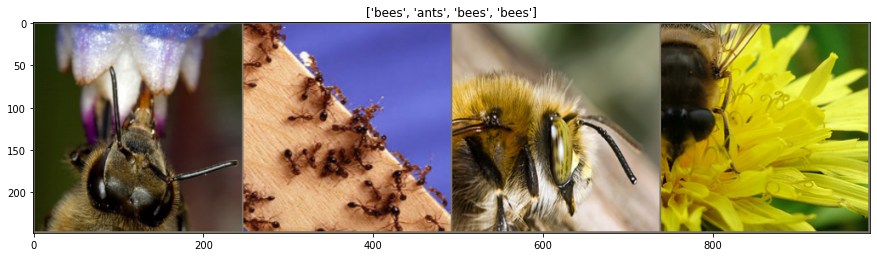

In [ ]:

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15, 12))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


# Получим 1 батч (картнки-метки) из обучающей выборки
inputs, classes = next(iter(dataloaders['train']))

# Расположим картинки рядом
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:

# 3) training loop 
#     - forward pass: prediction and loss
#     - backward pass: gradient
#     - updata weigth

# ===========================================
# 0)  training loop 
# ===========================================

      

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
  since = time.time()
  best_model_wts = model.state_dict()
  best_acc = 0.0
  
  #Ваш код здесь
  losses = {'train': [], "val": []}
  pbar = trange(num_epochs, desc="Epoch:")
  for epoch in pbar:
    for phase in ["train", "val"]:

      if phase == "train":
        scheduler.step()
        model.train(True)
      else:
        model.eval()
      # forward pass: predict and loss
      running_loss = 0.0
      running_corrects = 0

      for data in tqdm(dataloaders[phase], leave=False, desc=f"{phase} iter:"):
        x_batch, y_batch = data
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

         # инициализируем градиенты параметров
        if phase=="train":
          optimizer.zero_grad()

        # forward pass
        if phase == "eval":
          with torch.no_grad():
              y_pred = model(x_batch)
        else:
          y_pred = model(x_batch)

        # such as we solve the task of classification, output is a vector of probability of class membership vector
        # so the index of maximum probabilty is the answer to our task
        preds = torch.argmax(y_pred, -1)
        loss = criterion(y_pred, y_batch)

        # backward pass + оптимизируем только если это стадия обучения
        if phase == 'train':
          loss.backward()
          optimizer.step()

        # статистика
        running_loss += loss.item()
        running_corrects += int(torch.sum(preds == y_batch.data))
      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects / dataset_sizes[phase]
      losses[phase].append(epoch_loss)

      pbar.set_description('{} Loss: {:.4f} Acc: {:.4f}'.format(
                                    phase, epoch_loss, epoch_acc
                                ))
      # если достиглось лучшее качество, то запомним веса модели
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = model.state_dict()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
      time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  # загрузим лучшие веса модели
  model.load_state_dict(best_model_wts)
  return model, losses







In [ ]:
# Функция для измерения точности модели на валидационном датасете
def evaluate(model):
    model.eval()
    
    runninig_correct = 0
    for data in dataloaders['val']:
        # получаем картинки и метки
        inputs, labels = data
        
        # переносим на gpu, если возможно
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
            
        # forard pass
        output = model(inputs)
        _, predicted = torch.max(output, 1)
        
        runninig_correct += int(torch.sum(predicted == labels))
        
    return runninig_correct / dataset_sizes['val']

## Задание
Для каждой из следующих нейросетей:
* **AlexNet** (уже сделано в примере)
* **VGG16**
* **Inception_v3**

Напишите код и выведите результат (график лосса, accuracy и вывод примера классификации картинок с визализацией (с помощью функции `vizualize_model()`)) для трёх способов:
* Использование готовой нейросети **"из коробки"**
* Использование нейросети как **Feature Extractor**
* **Fine Tuning** нейросети

Для каждого пункта нужно:
* сделать с сетью то, что нужно в пункте ("из коробки", FE или FT)
* вывести график loss'а на обучающей и на валидационной выборке
* вывести качество модели (accuracy) на валидационной (тестовой) выборке
* (по желанию) использовать функцию visualize_model()

<h2 style="text-align: center;"><b>AlexNet</b></h2>
### AlexNet

**AlexNet** - нейронная сеть, которая победила в ILSVRC (соревнование по классификации картинок из ImageNet) в 2012 году и стала основой для многих других архитектур. Впервые она была представлена в статье  “ImageNet Classification with Deep Convolutional Neural Networks”, над которой работал Джоффри Хинтон - человек, которого многие называют отцом современного computer vision.

Архитектура описана на картинке ниже

<img src="https://www.learnopencv.com/wp-content/uploads/2018/05/AlexNet-1.png">

**AlexNet** состоит из 5 **сверточных** слоев, 3 **MaxPool** слоев и 2 **FullyConnected** слоев в конце. Обратите внимание, что в последнем пулинг слое окна, из которых берется максимум, пересекаются за счет того, что *stride*=2. Это изменение по сравнению с традиционным пулингом помогло снизить ошибку на 0.4%.

По сути **AlexNet** это самая базовая архитектура для сверточной сети после LeNet, которую мы уже писали на предыдущем занятии.

In [ ]:
# =================================
# 1) Model: copy the pretrained model
# =================================\

# in this se4ction we don't write a neural net but we take already trained neural network AlexNet

model = models.alexnet(pretrained = True)
model

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Видим, что на вход классификатору (classifier) подаётся *9216 признаков*. Это и будет размер входа для нашего нового классификатора.

* **Fine Tuning** способ

Сконфигурируем - изменим FC-слой и зададим *cost function* и *оптимизирующий алгоритм*:

(*по умолчанию backpropagation распространяется на все слои, поэтому здесь мы только заменяем FC-слой на свой классификатор*)

In [ ]:
# =================================
# 1) Model: set loss and optimizer 
#           set our castom fully connected classifier and insert it into alexnet
# =================================

# num_fetures is a dimension of vector in fc layer
num_features = 9216 # see the preced block above

# replace the standart fc layer on our classifier
model.classifier = nn.Linear(num_features, 2)

model = model.to(device)

# loss function
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-4

# optimizer
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [ ]:
model, losses = train_model(model, loss_fn, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch::   0%|          | 0/25 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

Training complete in 1m 36s
Best val Acc: 0.895425


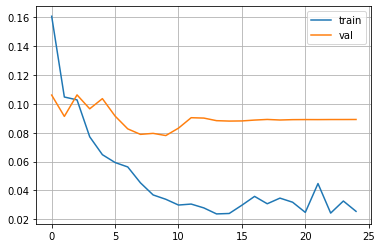

In [ ]:

plt.plot(losses["train"], label="train")
plt.plot(losses["val"], label="val")
plt.grid()
plt.legend()

In [ ]:
# seve wegths on hard-disk in desctop
torch.save(model.state_dict(), 'AlexNet_fine_tune.pth')

In [ ]:
model.load_state_dict(torch.load('AlexNet_fine_tune.pth'))

<All keys matched successfully>

In [ ]:
print("Accuracy: {0:.4f}".format(evaluate(model)))

Accuracy: 0.8954


* **Feature Extractor** способ:

мы обучаем все слои, сейчас

In [ ]:
model_extractor = models.alexnet(pretrained=True)
for param in model_extractor.parameters():
    print(param.requires_grad)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [ ]:
# freeze the parameters of our model:
for param in model_extractor.parameters():
  param.requires_grad = False

num_features = 9216
model_extractor.classifier = nn.Linear(num_features, 2)
model_extractor = model_extractor.to(device)

# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer have a special settings
# we learnin onle the last layer (our casto, classifier)
optimizer = optim.Adam(model_extractor.classifier.parameters(), lr = 1e-4)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
model, losses = train_model(model, loss_fn, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch::   0%|          | 0/25 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

Training complete in 1m 32s
Best val Acc: 0.895425


In [ ]:
torch.save(model_extractor.state_dict(), 'AlexNet_extractor.pth')
model_extractor.load_state_dict(torch.load('AlexNet_extractor.pth'))
print("Accuracy: {0:.4f}".format(evaluate(model_extractor)))

Accuracy: 0.5621


* **Смешанный** способ:
Мы будем обучать не только последний **fully connected** слой, но и несколько предпоследних

In [ ]:
model_mixed = models.alexnet(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
layers_to_unfreeze = 5

# Выключаем подсчет градиентов для слоев, которые не будем обучать
for param in model_mixed.features[:-layers_to_unfreeze].parameters():
    param.requires_grad = False


# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 9216
# Заменяем Fully-Connected слой на наш линейный классификатор
model_mixed.classifier = nn.Linear(num_features, 2)

# Использовать ли GPU
if use_gpu:
    model_mixed = model_mixed.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем последние layers_to_unfreeze слоев из сверточной части и fully connected слой 
# parameters() возвращает просто список тензоров парамтеров, поэтому два таких списка можно сложить
optimizer = optim.Adam(list(model_mixed.features.parameters())[-layers_to_unfreeze:] + 
                      list(model_mixed.classifier.parameters()), lr=1e-4)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
_, losses = train_model(model_mixed, loss_fn, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch::   0%|          | 0/25 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

Training complete in 1m 26s
Best val Acc: 0.921569


## Еще один метод

Можно не замораживать все первые слои, а делать так, чтобы шаг градиента на них был меньше. Интерфейс оптимизатора позволяет это делать.

In [ ]:
model_diff_lr = models.alexnet(pretrained=True)
model_diff_lr.classifier = nn.Linear(num_features, 2)
optimizer = torch.optim.Adam([
                              {"params": model_diff_lr.classifier.parameters()},
                              {"params": model_diff_lr.features.parameters(), "lr": 1e-5}
                            ], 
                             lr=1e-4
                             )
сriterion = nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model_diff_lr.to(device)
_, losses = train_model(model_diff_lr, сriterion, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch::   0%|          | 0/25 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

Training complete in 1m 30s
Best val Acc: 0.915033


## VGG16

Один **сверточный** слой с фильтром 5$\times$5 можно заменить двумя подряд идущими слоями с фильтрами размером 3$\times$3, так как **воспринимаемая область** картинки у них будет одинаковой. При этом уменьшиться количество параметров, поэтому такую сеть будет легче обучать. 

На момент создания VGG люди уже заметили, что чем больше слоев в нейросети, тем выше ее точность. Заменяя большие фильтры на несколько фильтров 3$\times$3 исследователи получили глубокую нейросеть с меньшим количеством параметров. Архитектура VGG-16 (версии VGG с 16 слоями) представлена на картинке ниже:

<img src="https://cdn-images-1.medium.com/max/1040/1*0Tk4JclhGOCR_uLe6RKvUQ.png">

Когда говорят **VGG**, то чаще всего имеют ввиду **VGG-16** или **VGG-19**. Более глубоких версий **VGG** нет, так как после 19 слоев точность начинает падать.

Чтобы добиться высоких результатов в соревновании при обучении и валидации нейросети использовались дополнительные премы, подробнее о которых можно прочитать в [статье на Medium](https://medium.com/coinmonks/paper-review-of-vggnet-1st-runner-up-of-ilsvlc-2014-image-classification-d02355543a11).

In [ ]:
#let's download the VGG pretrained model and try to use it
model_extractor = models.vgg16(pretrained=True)
model_extractor

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:

# freeze the whegths
for param in model_extractor.parameters():
  param.requires_grad = False

# see to the previous block 
num_features = 25088
model_extractor.classifier = nn.Linear(num_features, 2)
model_extractor.to(device)

# set the loss fucntion
loss_fn = nn.CrossEntropyLoss()

# set the optimizer
optimizer = optim.SGD(model_extractor.classifier.parameters(), lr=1e-3, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
model_extractor, losses = train_model(model_extractor, loss_fn, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch::   0%|          | 0/25 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

train iter::   0%|          | 0/61 [00:00<?, ?it/s]

val iter::   0%|          | 0/39 [00:00<?, ?it/s]

Training complete in 1m 57s
Best val Acc: 0.941176


### Inception_v3

### Рассмотрим идею, которая подтолкнула исследователей к созданию этой архитектуры.

Площадь, которую занимает классифицируемый объект, может очень сильно отличаться. Пример на картинке ниже: 

<img src="https://cdn-images-1.medium.com/max/1040/1*aBdPBGAeta-_AM4aEyqeTQ.jpeg">


* Для извлечения информации с большой площади лучше всего подходят **большие** фильтры, и наоборот для маленьких объектов лучше **маленькие** фильтры. 
* Глубокие нейронные сети намного сложнее обучать: в них появляется проблема **затухания градиента** и они **переобучаются**.
Чтобы решить первую проблему исследователи придумали **Incepton** модуль, который применяет фильтры разного размера и затем склеивает полученные каналы. При этом извлекается как информация из больших объектов, так и из маленьких. Простейшая реализация модуля выглядит так:
<img src="https://cdn-images-1.medium.com/max/1040/1*DKjGRDd_lJeUfVlY50ojOA.png">

Реализацию можно сделать более эффективной, если сначала уменьшить количество каналов с помощью **сверточного слоя** 1$\times$1 и лишь затем применить **слой** с фильтрами 5$\times$5. Сокращение вычислений происходит за счет того, что мы сначала **уменьшаем размерность** данных и лишь затем преобразовываем их. Продвинутая реализация:
<img src="https://cdn-images-1.medium.com/max/1040/1*U_McJnp7Fnif-lw9iIC5Bw.png">

Сеть состоит из **корня** (нескольких сверточных слоев) и **Inception** модулей идущих за ним. Оранжевым прямоугольников выделен корень, а фиолетовыми - **вспомогательные классификаторы**. Именно они помогают бороться со второй проблемой, которую мы упомянули ранее. Наша функция потерь - взвешенная сумма **LogLoss** на двух **вспомогательных классификаторах** и **основном** в конце нейронной сети.
<img src="https://cdn-images-1.medium.com/max/1040/1*uW81y16b-ptBDV8SIT1beQ.png">

После Inception v1 были представлены 2, 3 и 4 версии, пррочитать о которых вы можете  в [статье на Medium](https://towardsdatascience.com/a-simple-guide-to-the-versions-of-the-inception-network-7fc52b863202).

In [ ]:
model_extractor = models.inception_v3(pretrained=True)
model_extractor

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
# Нужно поменять размер картинок на 299, иначе будет ошибка, так как размерность станет отрицательной.
# Это вызвано тем, что нейросеть изначально обучалась на картинках размера 299.

# Результирующий размер картинок определяется трансформациями
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(299),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Сам объект датасета
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

# специальный класс для загрузки данных в виде батчей
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=2)
               for x in ['train', 'val']}

In [ ]:
# the name AuxLoqits and Mixed_7c we get from model 
# the see before previousle block
model_extractor.AuxLogits.fc = nn.Linear(768, 2)
model_extractor.fc = nn.Linear(2048, 2)


In [ ]:



# num_features -- это размерность вектора фич, поступающего на вход FC-слою
#num_features = 25088
# Заменяем Fully-Connected слой на наш линейный классификатор
#model_extractor.classifier = nn.Linear(num_features, 2)

model_extractor.to(device)

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем только классификатор
optimizer = optim.Adam(model_extractor.parameters(), lr=1e-4)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
model_extractor.aux_logits = False
model_extractor, losses = train_model(model_extractor, loss_fn, optimizer, exp_lr_scheduler, num_epochs=25)

NameError: ignored

In [ ]:
torch.save(model_extractor.state_dict(), 'Inceptionv3.pth')
model_extractor.load_state_dict(torch.load('Inceptionv3.pth'))
print("Accuracy: {0:.4f}".format(evaluate(model_extractor)))

### Resnet

Следующая илея касается проблемы затухания градиентов. Чем больше слоев, тем хуже они проходят при backprop.

$$
\frac{\partial F}{\partial w_1} \times \frac{\partial F}{\partial w_2} \times \dots \times\frac{\partial F}{\partial w_n}
$$

Поэтому мы как бы можем прокидывать их в более глубокие слои с помощью residual соединений. А значит можем делать сети ГЛУБЖЕ...

![](https://www.machinelearningmastery.ru/img/0-145407-381989.png)

### ResNext

Но здесь мы сталкиваемся с проблемой. Мы снова получили лишь один путь для фичей. Давайте попробуем в некотором роде обхединить идеи последних двух пунктов.

![](https://www.programmersought.com/images/955/19ca8284fafed90cdfbdc9b103ae064b.png)

Итак введем еще одну размерность -- число путей. В оригинальной она называется coordinality.

$\mathcal{F}(\mathbf{x})=\sum_{i=1}^{C} \mathcal{T}_{i}(\mathbf{x})$

Теперь давайте думать, как можно оптимизировать такую архитектуру с точки зрения вычислений.

![](https://miro.medium.com/max/1000/1*cIm3uy7eNvEchxRbBeBScQ.png)

Картинка сверху очень содержательная. Все три блока на самом деле эквивалентны с точки зрения математики. Итак, давайте посмотрим на переход (a) -> (b):
Вместо того, чтобы складывать большие тензоры в конце, давайте просто конкатенировать по размерности каналов маленькие. А затем уже применим свертку 1х1 один раз.

(b) -> (c):

Второй переход потребует от нас чуть больше ментальных усилий. Для начал разберемся, что такое group-свертка. В обычном сверточном слое происходит следующее:

![](https://blog.yani.ai/assets/images/posts/2017-08-10-filter-group-tutorial/convlayer.svg)

Серым изображены тензоры фичей до и после свертки, а желтым -- сами ядра сверток, при этом одна "полоска" этих сверток соответствует одному каналу выходного тензора. Таким образом у нас в каждой полоске $c_1$ сверток, а полосок всего $c_2$. Число параметров в таком случае $N_1 = c_1 \cdot c_2$.

Запомним это число.

Теперь давайте разделим входной и выходной тензор на две части:

![](https://blog.yani.ai/assets/images/posts/2017-08-10-filter-group-tutorial/filtergroups2.svg)

Теперь давайте попытаемся перевести первую половинку входного тензора в первую половинку выходного. Для этого нам понадобится $c_2 / 2$ "полосок" длинной $c_1 / 2$. Проделаем то же самое с оставшимися половинками. А теперь магия: сколько в итоге праметров мы получим? $N_2 = 2\cdot(c_1/2 \cdot c_2/2) < c_1\cdot c_2 = N_1$.

[Про group-свертки.](https://blog.yani.ai/filter-group-tutorial/)

[Оригинальная cтатья про ResNeXT](https://https://arxiv.org/pdf/1611.05431.pdf)


## Efficient Net



Движемся дальше. Поговорим об эффективности более подробно. До этого архитектуры сетей, можно сказать, подбирались руками. Так у нас есть ResNet50, а не ResNet54 со свертками 3x3 а не 4x4.

Но если у нас есть достаточно ресурсов, то можно попробовать обучить алгоритм, который будет подбирать правильные параметры для слоев. Для начала нужно определить какие бывают методы для увеличения сети и запустить по ним grid search:

![](https://1.bp.blogspot.com/-Cdtb97FtgdA/XO3BHsB7oEI/AAAAAAAAEKE/bmtkonwgs8cmWyI5esVo8wJPnhPLQ5bGQCLcBGAs/s640/image4.png)

Затем основываясь на основе этих данны можно получить оптимальную архитектуру длясвоего числа параметров

![](https://1.bp.blogspot.com/-DjZT_TLYZok/XO3BYqpxCJI/AAAAAAAAEKM/BvV53klXaTUuQHCkOXZZGywRMdU9v9T_wCLcBGAs/s640/image2.png)

И оказывается, что даже самая маленькая сеть будет показывать лучшие результаты.

![](https://1.bp.blogspot.com/-oNSfIOzO8ko/XO3BtHnUx0I/AAAAAAAAEKk/rJ2tHovGkzsyZnCbwVad-Q3ZBnwQmCFsgCEwYBhgL/s640/image3.png)

Подробнее [здесь](https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html).

1). *cs231n: http://cs231n.github.io/transfer-learning/*

2). *Туториал на PyTorch Tutorials: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial*

3). *Статья на Medium про TL в PyTorch: https://medium.com/@14prakash/almost-any-image-classification-problem-using-pytorch-i-am-in-love-with-pytorch-26c7aa979ec4*  

In [ ]:
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b2')